## Credit Transition Matrices

### Original Credit Transition Matrix

The original Credit Transition Matrix (CTM) represents the probabilities of obligors transitioning between different credit ratings, withdrawing, or defaulting over a quarter. Each row sums to 1, indicating that every obligor must transition to one of the possible states.

**Description:**
- This matrix shows the likelihood of obligors remaining in their current rating, moving to a different rating, withdrawing, or defaulting.
- The probabilities are based on historical data and are specific to each credit rating.


In [1]:
import numpy as np
import pandas as pd

def generate_credit_transition_matrix_with_withdraw_prob(withdraw_prob):
    n_ratings = 10
    n_columns = 12  # Including withdraw and default columns
    matrix = np.zeros((n_ratings, n_columns))
    
    stddev = withdraw_prob / 10
    
    # Specified default rates
    default_rates = np.array([0.00005, 0.0001, 0.0004, 0.0009, 0.0025, 
                              0.007, 0.0128, 0.0601, 0.1575, 0.3537])
    
    # Main diagonal probabilities for each rating
    main_diagonal_probs = [0.94, 0.92, 0.90, 0.87, 0.85, 0.82, 0.80, 0.77, 0.73, 0.58]

    for i in range(n_ratings):
        # Assign specified default probability
        default_prob = default_rates[i]
        
        # Assign withdraw probability following a normal distribution centered around withdraw_prob
        withdraw_prob_sample = np.random.normal(withdraw_prob, stddev)
        
        # Ensure withdraw probability is within the valid range [0, 1]
        withdraw_prob_sample = max(0, min(withdraw_prob_sample, 1))
        
        # Calculate the remaining probability for other transitions
        remaining_prob = 1 - default_prob - withdraw_prob_sample
        
        # Set main diagonal probability
        main_diagonal = np.random.normal(main_diagonal_probs[i], main_diagonal_probs[i]/100)
        
        # Calculate side probabilities based on the number of adjacent ratings
        num_adjacent_ratings = min(i, n_ratings - 1 - i)
        if i == 0:  # Top rating
            side_prob = (remaining_prob - main_diagonal) / 2  # Only two adjacent ratings (downwards)
        elif i == 9:  # Bottom rating
            side_prob = (remaining_prob - main_diagonal) / 2  # Only two adjacent ratings (upwards)
        elif num_adjacent_ratings == 1:
            side_prob = (remaining_prob - main_diagonal) / 3
        elif num_adjacent_ratings == 2:
            side_prob = (remaining_prob - main_diagonal) / 4
        elif num_adjacent_ratings == 3:
            side_prob = (remaining_prob - main_diagonal) / 5
        else:
            side_prob = (remaining_prob - main_diagonal) / 6
        
        # Set main diagonal
        matrix[i, i] = main_diagonal
        
        # Set probabilities for adjacent ratings with randomness
        for j in range(1, 4):
            if i - j >= 0:  # Lower adjacent ratings, i.e. higher ratings
                matrix[i, i - j] = max(0, side_prob * (4 - j) * np.random.uniform(0.7, 0.9))
            if i + j < n_ratings:  # Upper adjacent ratings, i.e. lower ratings
                matrix[i, i + j] = max(0, side_prob * (4 - j) * np.random.uniform(1.1, 1.3))
        
        # Normalize probabilities for other states while keeping main diagonal fixed
        before_i = np.sum(matrix[i, :i])
        after_i = np.sum(matrix[i, i+1:n_ratings])
        total_adjacent_prob = before_i + after_i
        if total_adjacent_prob > 0:
            matrix[i, :i] *= (remaining_prob - main_diagonal) / total_adjacent_prob
            matrix[i, i+1:n_ratings] *= (remaining_prob - main_diagonal) / total_adjacent_prob
        
        matrix[i, -2] = withdraw_prob_sample  # Withdraw probability
        matrix[i, -1] = default_prob  # Default probability

    # Ensure transition probabilities for Rating 1 and Rating 10 are correctly adjusted
    matrix[0, 1] = max(matrix[0, 1], 1e-5)  # Ensure non-zero probability to transition to Rating 2
    matrix[0, 2] = max(matrix[0, 2], 1e-5)  # Ensure non-zero probability to transition to Rating 3
    matrix[9, 8] = max(matrix[9, 8], 1e-5)  # Ensure non-zero probability to transition to Rating 9
    matrix[9, 7] = max(matrix[9, 7], 1e-5)  # Ensure non-zero probability to transition to Rating 8
    
    # Define row and column labels
    row_labels = [f'Rating {i+1}' for i in range(10)]
    column_labels = [f'Rating {i+1}' for i in range(10)] + ['Withdraw', 'Default']

    # Create a DataFrame with labels
    transition_matrix_df = pd.DataFrame(matrix, index=row_labels, columns=column_labels)

    return transition_matrix_df

# Example usage
withdraw_prob = 0.03  # Centered around value% withdraw probability
transition_matrix_df = generate_credit_transition_matrix_with_withdraw_prob(withdraw_prob)
transition_matrix_df

,Rating 1,Rating 2,Rating 3,Rating 4,Rating 5,Rating 6,Rating 7,Rating 8,Rating 9,Rating 10,Withdraw,Default
Rating 1,0.932197,0.019136,0.012981,0.005764,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.029872,0.00005
Rating 2,0.013928,0.915563,0.021019,0.013906,0.007054,0.000000,0.000000,0.000000,0.000000,0.000000,0.028430,0.00010
Rating 3,0.010822,0.018037,0.897074,0.024315,0.015137,0.007570,0.000000,0.000000,0.000000,0.000000,0.026644,0.00040
Rating 4,0.005135,0.011374,0.016186,0.886190,0.023711,0.014879,0.007270,0.000000,0.000000,0.000000,0.034354,0.00090
Rating 5,0.000000,0.007264,0.014526,0.020969,0.852630,0.034516,0.021609,0.010444,0.000000,0.000000,0.035542,0.00250
Rating 6,0.000000,0.000000,0.010721,0.018580,0.025803,0.820593,0.040641,0.031215,0.015172,0.000000,0.030276,0.00700
Rating 7,0.000000,0.000000,0.000000,0.010241,0.021090,0.028941,0.796634,0.049208,0.032909,0.015500,0.032678,0.01280
Rating 8,0.000000,0.000000,0.000000,0.000000,0.009963,0.022039,0.027146,0.778749,0.042841,0.028088,0.031075,0.06010
Rating 9,0.000000,0.000000,0.000000,0.000000,0.000000,0.007535,0.016044,0.020844,0.731584,0.036449,0.030044,0.15750
Rating 10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004961,0.010210,0.015244,0.584246,0.031638,0.35370


### 50% Reweighted Withdraw Probability Credit Transition Matrix

The reweighted CTM shows the changes in transition probabilities when the withdraw probability is halved (reduced by 50%). As the withdraw probability decreases, the remaining probability mass is redistributed among the other possible transitions, increasing the likelihood of transitioning to other ratings or defaulting.

**Description:**
- By reducing the withdraw probability, the matrix reflects higher probabilities for obligors to transition to different credit ratings or default.
- This scenario helps in understanding the impact of changes in withdrawal rates on overall credit transitions.


In [12]:
import numpy as np
import pandas as pd

def redistribute_half_withdraw_prob(transition_matrix_df):
    transition_matrix = transition_matrix_df.values
    n_ratings = transition_matrix.shape[0]
    
    # Create a new matrix to store the adjusted probabilities
    adjusted_matrix = np.zeros((n_ratings, n_ratings + 1))
    
    for i in range(n_ratings):
        withdraw_prob = transition_matrix[i, -2]
        default_prob = transition_matrix[i, -1]
        remaining_prob = 1 - withdraw_prob - default_prob
        
        existing_probs = transition_matrix[i, :n_ratings]
        sum_existing_probs = np.sum(existing_probs)
        
        # Distribute half of the withdraw prob proportionally among existing probabilities
        proportional_withdraw_existing = (existing_probs / sum_existing_probs) * (0.5 * withdraw_prob)
        
        for j in range(n_ratings):
            adjusted_matrix[i, j] = (existing_probs[j] + proportional_withdraw_existing[j]) / (1 - 0.5 * withdraw_prob)
        
        # Adjust default probability
        adjusted_matrix[i, -1] = default_prob / (1 - 0.5 * withdraw_prob)
    
    # Define row and column labels
    row_labels = [f'Rating {i+1}' for i in range(10)]
    column_labels = [f'Rating {i+1}' for i in range(10)] + ['Default']

    # Create a DataFrame with labels
    adjusted_transition_matrix_df = pd.DataFrame(adjusted_matrix, index=row_labels, columns=column_labels)
    
    return adjusted_transition_matrix_df

# Example usage
adjusted_transition_matrix_df = redistribute_half_withdraw_prob(transition_matrix_df)
adjusted_transition_matrix_df

,Rating 1,Rating 2,Rating 3,Rating 4,Rating 5,Rating 6,Rating 7,Rating 8,Rating 9,Rating 10,Default
Rating 1,0.960901,0.019726,0.013380,0.005942,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000051
Rating 2,0.014335,0.942356,0.021634,0.014313,0.007261,0.000000,0.000000,0.000000,0.000000,0.000000,0.000101
Rating 3,0.011119,0.018531,0.921635,0.024980,0.015552,0.007778,0.000000,0.000000,0.000000,0.000000,0.000405
Rating 4,0.005318,0.011779,0.016762,0.917733,0.024555,0.015408,0.007529,0.000000,0.000000,0.000000,0.000916
Rating 5,0.000000,0.007532,0.015062,0.021743,0.884093,0.035789,0.022406,0.010830,0.000000,0.000000,0.002545
Rating 6,0.000000,0.000000,0.011057,0.019162,0.026612,0.846307,0.041915,0.032193,0.015647,0.000000,0.007108
Rating 7,0.000000,0.000000,0.000000,0.010589,0.021808,0.029925,0.823729,0.050882,0.034029,0.016027,0.013013
Rating 8,0.000000,0.000000,0.000000,0.000000,0.010293,0.022769,0.028045,0.804564,0.044261,0.029019,0.061049
Rating 9,0.000000,0.000000,0.000000,0.000000,0.000000,0.007791,0.016590,0.021553,0.756474,0.037689,0.159902
Rating 10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005171,0.010641,0.015888,0.608915,0.359385


### Withdraw Removed Credit Transition Matrix

The Withdraw Removed CTM removes the withdrawal option entirely, redistributing the withdrawal probability among the other states.

**Description:**
- With withdrawals removed, the entire probability mass is distributed among the remaining ratings and default.
- This matrix provides insights into pure credit rating transitions and default likelihoods without considering the withdrawal factor.

In [3]:
import numpy as np
import pandas as pd

def redistribute_withdraw_prob(transition_matrix_df):
    transition_matrix = transition_matrix_df.values
    n_ratings = transition_matrix.shape[0]
    
    # Create a new matrix to store the adjusted probabilities
    adjusted_matrix = np.zeros((n_ratings, n_ratings + 1))
    
    for i in range(n_ratings):
        withdraw_prob = transition_matrix[i, -2]
        default_prob = transition_matrix[i, -1]
        remaining_prob = 1 - withdraw_prob

        for j in range(n_ratings):
            adjusted_matrix[i, j] = transition_matrix[i, j] + withdraw_prob * (transition_matrix[i, j] / remaining_prob)
        
        adjusted_matrix[i, -1] = default_prob + withdraw_prob * (default_prob / remaining_prob)

    # Define row and column labels
    row_labels = [f'Rating {i+1}' for i in range(10)]
    column_labels = [f'Rating {i+1}' for i in range(10)] + ['Default']

    # Create a DataFrame with labels
    adjusted_transition_matrix_df = pd.DataFrame(adjusted_matrix, index=row_labels, columns=column_labels)
    
    return adjusted_transition_matrix_df

# Example usage
withdraw_removed_transition_matrix_df = redistribute_withdraw_prob(transition_matrix_df)
withdraw_removed_transition_matrix_df

,Rating 1,Rating 2,Rating 3,Rating 4,Rating 5,Rating 6,Rating 7,Rating 8,Rating 9,Rating 10,Default
Rating 1,0.960901,0.019726,0.013380,0.005942,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000052
Rating 2,0.014335,0.942354,0.021634,0.014313,0.007261,0.000000,0.000000,0.000000,0.000000,0.000000,0.000103
Rating 3,0.011119,0.018531,0.921630,0.024980,0.015552,0.007778,0.000000,0.000000,0.000000,0.000000,0.000411
Rating 4,0.005318,0.011779,0.016762,0.917718,0.024555,0.015408,0.007529,0.000000,0.000000,0.000000,0.000932
Rating 5,0.000000,0.007532,0.015062,0.021742,0.884051,0.035787,0.022405,0.010829,0.000000,0.000000,0.002592
Rating 6,0.000000,0.000000,0.011055,0.019160,0.026609,0.846212,0.041910,0.032189,0.015646,0.000000,0.007219
Rating 7,0.000000,0.000000,0.000000,0.010586,0.021803,0.029918,0.823546,0.050870,0.034021,0.016023,0.013232
Rating 8,0.000000,0.000000,0.000000,0.000000,0.010283,0.022746,0.028016,0.803725,0.044215,0.028988,0.062028
Rating 9,0.000000,0.000000,0.000000,0.000000,0.000000,0.007768,0.016541,0.021490,0.754244,0.037578,0.162378
Rating 10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005124,0.010543,0.015742,0.603335,0.365256


###  Simulate Transitions & ECL calculation:

- Initialize the count of obligors for each rating.
- For each quarter, compute transitions based on the transition matrix.
- Track cumulative withdrawals, defaults, and survivors for each rating.
- Calculate the True ECL for each quarter and for each rating based on the transitions to default state.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_transitions(n_obligors, transition_matrix, quarters=11, lgd=1.0, ead=1.0):
    n_ratings = transition_matrix.shape[0]  # Number of ratings
    n_columns = transition_matrix.shape[1]  # Number of states including Withdraw and Default
    
    cumulative_withdraws = np.zeros((quarters, n_ratings))
    cumulative_defaults = np.zeros((quarters, n_ratings))
    cumulative_survivors = np.zeros((quarters, n_ratings))
    ecl_per_quarter = np.zeros((quarters, n_ratings))  # To store ECL for each quarter and rating

    # Initialize obligors matrix with shape (quarters, n_ratings, n_ratings)
    obligors = np.zeros((quarters, n_ratings, n_ratings))
    for i in range(n_ratings):
        original_obligors_count = n_obligors / n_ratings  # Distribute obligors equally at the start
        obligors[0, i, i] = original_obligors_count
        cumulative_survivors[0, i] = original_obligors_count

    for t in range(1, quarters):
        for i in range(n_ratings):  # Only consider ratings, exclude Withdraw and Default columns
            for j in range(n_ratings):  # For each rating's distribution vector
                if obligors[t-1, i, j] > 0:
                    available_obligors = obligors[t-1, i, j]

                    transitions = available_obligors * transition_matrix.iloc[j].values
                    transitions = np.round(transitions).astype(int)

                    # Ensure transitions do not exceed available obligors
                    while transitions.sum() > available_obligors:
                        transitions[np.argmax(transitions)] -= 1

                    # Update obligors for next state
                    obligors[t, i, :] += transitions[:n_ratings]

                    # Accumulate withdraws and defaults for each rating
                    if cumulative_withdraws[t, i] == 0 and cumulative_defaults[t, i] == 0:
                        cumulative_withdraws[t, i] = cumulative_withdraws[t - 1, i]
                        cumulative_defaults[t, i] = cumulative_defaults[t - 1, i]
                    cumulative_withdraws[t, i] += transitions[-2]
                    cumulative_defaults[t, i] += transitions[-1]
                    
                    # Accumulate survivors for each rating
                    cumulative_survivors[t, i] += np.sum(transitions[:n_ratings])
                    
                    # Calculate ECL for the current quarter and rating
                    default_count = transitions[-1]
                    ecl_per_quarter[t, i] += default_count * lgd * ead

    # Calculate cumulative ECL for each rating
    cumulative_ecl = np.sum(ecl_per_quarter, axis=0)

    return cumulative_withdraws, cumulative_defaults, cumulative_survivors, obligors, ecl_per_quarter, cumulative_ecl

# Example usage with a sample transition matrix and withdraw counts
# Simulate the transitions for 100,000 obligors over 2 years (8 quarters)
n_obligors = 100000
quarters = 11
cumulative_withdraws, cumulative_defaults, cumulative_survivors, obligors, ecl_per_quarter, cumulative_ecl = simulate_transitions(n_obligors, transition_matrix_df, quarters)

# Convert ecl_per_quarter to integers
ecl_per_quarter_int = ecl_per_quarter.astype(int)

# Convert ecl_per_quarter_int to a DataFrame
ecl_df = pd.DataFrame(ecl_per_quarter_int, columns=[f'Rating {i+1}' for i in range(10)])

# Add the quarter count as the index
ecl_df.index.name = 'Quarter'
ecl_df.reset_index(inplace=True)

ecl_df

,Quarter,Rating 1,Rating 2,Rating 3,Rating 4,Rating 5,Rating 6,Rating 7,Rating 8,Rating 9,Rating 10
0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,1,4,9,25,70,128,601,1575,3537
2,2,0,1,5,11,32,106,242,639,1297,2097
3,3,0,1,5,14,44,137,302,622,1042,1253
4,4,0,1,7,16,55,161,329,576,826,755
5,5,0,2,9,22,66,178,335,519,650,461
6,6,0,2,12,25,78,188,328,458,510,286
7,7,0,4,12,29,84,192,312,400,400,181
8,8,0,5,15,34,90,192,292,348,314,117
9,9,0,7,17,38,93,188,270,301,248,78


In [5]:
# Calculate 5-time ECL and 10-time ECL
ecl_5_time = np.sum(ecl_per_quarter[:6], axis=0)
ecl_10_time = np.sum(ecl_per_quarter[:11], axis=0)

# Convert ecl_per_quarter to integers
ecl_per_quarter_int = ecl_per_quarter.astype(int)

# Convert ecl_per_quarter_int to a DataFrame
ecl_df = pd.DataFrame(ecl_per_quarter_int, columns=[f'Rating {i+1}' for i in range(10)])
ecl_df.index.name = 'Quarter'

# Add the 5-time and 10-time ECL to the DataFrame
real_cl_summary_df = pd.DataFrame({
    'Rating': [f'Rating {i+1}' for i in range(10)],
    '5-time ECL': ecl_5_time,
    '10-time ECL': ecl_10_time
})

# Print the results
real_cl_summary_df

,Rating,5-time ECL,10-time ECL
0,Rating 1,0.0,0.0
1,Rating 2,6.0,31.0
2,Rating 3,30.0,106.0
3,Rating 4,72.0,237.0
4,Rating 5,222.0,664.0
5,Rating 6,652.0,1592.0
6,Rating 7,1336.0,2784.0
7,Rating 8,2957.0,4722.0
8,Rating 9,5390.0,7057.0
9,Rating 10,8103.0,8818.0


### ECL calculation using real withdraw counts and 50% withdraw reweighted CTM

- Obtain withdraw count of each iteration from simulation based on full CTM (with withdrawal columns)
- After each iteration, deduct withdrawal counts proportionally based on the counts of existing ratings and default ratings
- Calculate ECL of each iteration by obtaining new default counts.

In [6]:
import numpy as np
import pandas as pd

def simulate_transitions_matrix_with_withdraw_and_ecl(transition_matrix, cumulative_withdraws, quarters=11, lgd=1.0, ead=1.0):
    n_ratings = transition_matrix.shape[0]  # Number of ratings (excluding Withdraw and Default)
    n_columns = transition_matrix.shape[1]  # Number of states including Default
    
    cumulative_defaults = np.zeros((quarters, n_ratings))
    cumulative_survivors = np.zeros((quarters, n_ratings))
    ecl_per_quarter = np.zeros((quarters, n_ratings))  # To store ECL for each quarter and rating

    # Initialize obligors matrix with shape (quarters, n_ratings, n_ratings)
    obligors = np.zeros((quarters, n_ratings, n_ratings))
    for i in range(n_ratings):
        original_obligors_count = n_obligors / n_ratings  # Distribute obligors equally at the start
        obligors[0, i, i] = original_obligors_count
        cumulative_survivors[0, i] = original_obligors_count

    for t in range(1, quarters):
        for i in range(n_ratings):  # Only consider ratings, exclude Withdraw and Default columns
            for j in range(n_ratings):  # For each rating's distribution vector
                if obligors[t-1, i, j] > 0:
                    available_obligors = obligors[t-1, i, j]

                    transitions = available_obligors * transition_matrix.iloc[j].values
                    transitions = np.round(transitions).astype(int)

                    # Ensure transitions do not exceed available obligors
                    while transitions.sum() > available_obligors:
                        transitions[np.argmax(transitions)] -= 1

                    # Update obligors for next state
                    obligors[t, i, :] += transitions[:n_ratings]

                    # Accumulate defaults for each rating
                    cumulative_defaults[t, i] += transitions[-1]

                    # Accumulate survivors for each rating
                    cumulative_survivors[t, i] += np.sum(transitions[:n_ratings])
                    
                    # Calculate ECL for the current quarter and rating
                    default_count = transitions[-1]
                    ecl_per_quarter[t, i] += default_count * lgd * ead
        
        # Apply withdrawals after simulation
        for i in range(n_ratings):
            withdraw_count = cumulative_withdraws[t, i]
            survivors = cumulative_survivors[t, i]
            if withdraw_count > survivors:
                withdraw_count = survivors
            
            cumulative_survivors[t, i] -= withdraw_count

    ecl_df = pd.DataFrame(ecl_per_quarter, columns=[f'Rating {i+1}' for i in range(n_ratings)])
    return cumulative_defaults, cumulative_survivors, ecl_df


# Example usage
quarters = 11

cumulative_defaults, cumulative_survivors, ecl_df = simulate_transitions_matrix_with_withdraw_and_ecl(
    adjusted_transition_matrix_df, cumulative_withdraws, quarters
)

# Print the results in a readable format
def print_readable_matrix(matrix, title):
    readable_matrix = np.array2string(matrix, formatter={'float_kind':lambda x: "%.0f" % x})
    print(f"{title}:\n{readable_matrix}")

ecl_df

,Rating 1,Rating 2,Rating 3,Rating 4,Rating 5,Rating 6,Rating 7,Rating 8,Rating 9,Rating 10
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,4.0,9.0,25.0,71.0,130.0,610.0,1599.0,3594.0
2,0.0,1.0,5.0,11.0,36.0,111.0,253.0,672.0,1360.0,2220.0
3,0.0,1.0,5.0,15.0,48.0,147.0,329.0,675.0,1133.0,1383.0
4,0.0,2.0,7.0,20.0,64.0,179.0,371.0,647.0,929.0,869.0
5,0.0,2.0,10.0,25.0,77.0,207.0,391.0,601.0,758.0,552.0
6,0.0,4.0,14.0,31.0,92.0,224.0,395.0,550.0,614.0,357.0
7,0.0,5.0,17.0,37.0,104.0,236.0,390.0,497.0,499.0,234.0
8,0.0,7.0,19.0,44.0,117.0,245.0,376.0,447.0,405.0,157.0
9,0.0,8.0,22.0,50.0,125.0,248.0,360.0,399.0,330.0,108.0


In [7]:
import pandas as pd

# Sum for 5-year ECL (first 6 periods)
ecl_5_year = ecl_df.iloc[:6].sum(axis=0)

# Sum for 10-year ECL (first 11 periods)
ecl_10_year = ecl_df.iloc[:11].sum(axis=0)

# Create DataFrame
reweighed_ecl_summary_df = pd.DataFrame({
    'Rating': ecl_df.columns,
    '5-year ECL': ecl_5_year.values,
    '10-year ECL': ecl_10_year.values
})

reweighed_ecl_summary_df

,Rating,5-year ECL,10-year ECL
0,Rating 1,1.0,1.0
1,Rating 2,7.0,42.0
2,Rating 3,31.0,128.0
3,Rating 4,80.0,299.0
4,Rating 5,250.0,821.0
5,Rating 6,715.0,1915.0
6,Rating 7,1474.0,3334.0
7,Rating 8,3205.0,5454.0
8,Rating 9,5779.0,7897.0
9,Rating 10,8618.0,9552.0


### ECL calculation using real withdraw counts and withdraw removed CTM

In [8]:
cumulative_defaults, cumulative_survivors, ecl_df = simulate_transitions_matrix_with_withdraw_and_ecl(
    withdraw_removed_transition_matrix_df, cumulative_withdraws, quarters
)

# Print the results in a readable format
def print_readable_matrix(matrix, title):
    readable_matrix = np.array2string(matrix, formatter={'float_kind':lambda x: "%.0f" % x})
    print(f"{title}:\n{readable_matrix}")

ecl_df

,Rating 1,Rating 2,Rating 3,Rating 4,Rating 5,Rating 6,Rating 7,Rating 8,Rating 9,Rating 10
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,4.0,9.0,26.0,72.0,132.0,620.0,1624.0,3653.0
2,0.0,1.0,5.0,12.0,36.0,113.0,257.0,683.0,1378.0,2237.0
3,0.0,1.0,5.0,15.0,49.0,151.0,334.0,684.0,1144.0,1380.0
4,0.0,2.0,8.0,20.0,64.0,182.0,375.0,654.0,934.0,859.0
5,0.0,2.0,10.0,25.0,80.0,208.0,395.0,607.0,758.0,540.0
6,0.0,4.0,14.0,31.0,92.0,227.0,399.0,554.0,613.0,346.0
7,0.0,5.0,17.0,39.0,106.0,239.0,392.0,499.0,496.0,226.0
8,0.0,7.0,19.0,45.0,118.0,246.0,379.0,447.0,402.0,151.0
9,0.0,8.0,23.0,50.0,126.0,250.0,360.0,398.0,327.0,103.0


In [9]:
import pandas as pd

# Sum for 5-year ECL (first 6 periods)
ecl_5_year = ecl_df.iloc[:6].sum(axis=0)

# Sum for 10-year ECL (first 11 periods)
ecl_10_year = ecl_df.iloc[:11].sum(axis=0)

# Create DataFrame
removed_ecl_summary_df = pd.DataFrame({
    'Rating': ecl_df.columns,
    '5-year ECL': ecl_5_year.values,
    '10-year ECL': ecl_10_year.values
})

removed_ecl_summary_df

,Rating,5-year ECL,10-year ECL
0,Rating 1,1.0,1.0
1,Rating 2,7.0,42.0
2,Rating 3,32.0,131.0
3,Rating 4,81.0,303.0
4,Rating 5,255.0,833.0
5,Rating 6,726.0,1936.0
6,Rating 7,1493.0,3363.0
7,Rating 8,3248.0,5502.0
8,Rating 9,5838.0,7943.0
9,Rating 10,8669.0,9568.0


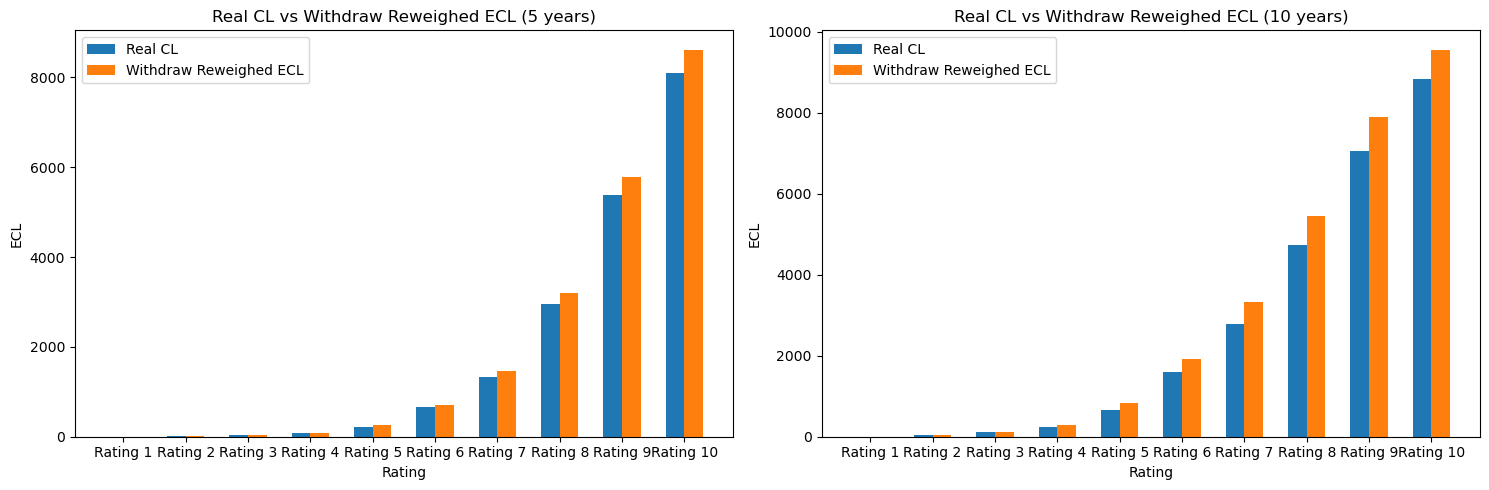

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot Real CL vs Withdraw Reweighed ECL for 5 years
width = 0.3
x = range(len(real_cl_summary_df['Rating']))
axs[0].bar(x, real_cl_summary_df['5-time ECL'], width=width, label='Real CL')
axs[0].bar([i + width for i in x], reweighed_ecl_summary_df['5-year ECL'], width=width, label='Withdraw Reweighed ECL')
axs[0].set_title('Real CL vs Withdraw Reweighed ECL (5 years)')
axs[0].set_xlabel('Rating')
axs[0].set_ylabel('ECL')
axs[0].set_xticks([i + width/2 for i in x])
axs[0].set_xticklabels(real_cl_summary_df['Rating'])
axs[0].legend()

# Plot Real CL vs Withdraw Reweighed ECL for 10 years
axs[1].bar(x, real_cl_summary_df['10-time ECL'], width=width, label='Real CL')
axs[1].bar([i + width for i in x], reweighed_ecl_summary_df['10-year ECL'], width=width, label='Withdraw Reweighed ECL')
axs[1].set_title('Real CL vs Withdraw Reweighed ECL (10 years)')
axs[1].set_xlabel('Rating')
axs[1].set_ylabel('ECL')
axs[1].set_xticks([i + width/2 for i in x])
axs[1].set_xticklabels(real_cl_summary_df['Rating'])
axs[1].legend()

plt.tight_layout()
plt.show()


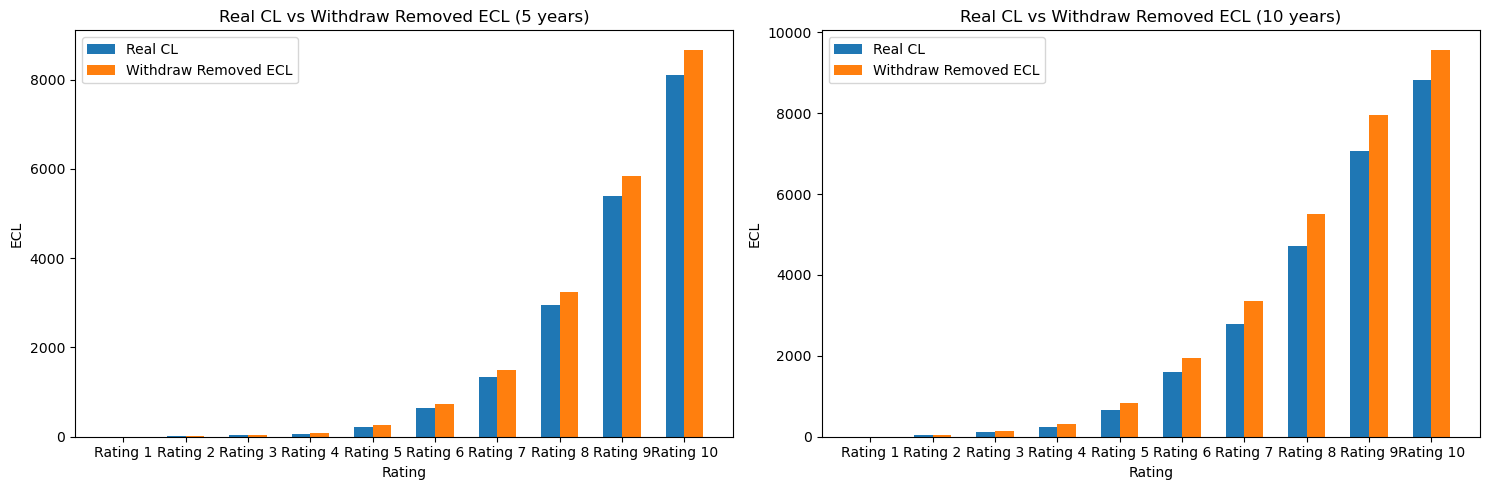

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot Real CL vs Withdraw Removed ECL for 5 years
width = 0.3
x = range(len(real_cl_summary_df['Rating']))
axs[0].bar(x, real_cl_summary_df['5-time ECL'], width=width, label='Real CL')
axs[0].bar([i + width for i in x], removed_ecl_summary_df['5-year ECL'], width=width, label='Withdraw Removed ECL')
axs[0].set_title('Real CL vs Withdraw Removed ECL (5 years)')
axs[0].set_xlabel('Rating')
axs[0].set_ylabel('ECL')
axs[0].set_xticks([i + width/2 for i in x])
axs[0].set_xticklabels(real_cl_summary_df['Rating'])
axs[0].legend()

# Plot Real CL vs Withdraw Removed ECL for 10 years
axs[1].bar(x, real_cl_summary_df['10-time ECL'], width=width, label='Real CL')
axs[1].bar([i + width for i in x], removed_ecl_summary_df['10-year ECL'], width=width, label='Withdraw Removed ECL')
axs[1].set_title('Real CL vs Withdraw Removed ECL (10 years)')
axs[1].set_xlabel('Rating')
axs[1].set_ylabel('ECL')
axs[1].set_xticks([i + width/2 for i in x])
axs[1].set_xticklabels(real_cl_summary_df['Rating'])
axs[1].legend()

plt.tight_layout()
plt.show()